In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf
from datetime import datetime, timedelta

In [2]:
# Function to fetch and prepare stock data
def fetch_data(stock_symbol, start_date, end_date):
    """Fetch historical stock data from Yahoo Finance."""
    data = yf.download(stock_symbol, start=start_date, end=end_date)
    return data[['Open', 'High', 'Low', 'Close']]

# Function to create datasets for LSTM input and output
def create_dataset(data, time_steps=60):
    """Prepare the dataset for training the LSTM model."""
    X, y = [], []
    for i in range(len(data) - time_steps - 1):  # Predict one day ahead
        X.append(data[i:i + time_steps])  # Last 60 days as input
        y.append(data[i + time_steps])    # The price on the next day as output
    return np.array(X), np.array(y)

# Get user input for the stock symbol
stock_symbol = input("Enter the stock symbol (e.g., AAPL): ")

# Get current date
end_date = datetime.today().strftime('%Y-%m-%d')  # Current date as string (format: YYYY-MM-DD)
start_date = "2010-01-01"  # Start date for data

# Fetch stock data for the given symbol and date range
data = fetch_data(stock_symbol, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [3]:
# Scale the data using MinMaxScaler to normalize values between 0 and 1
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Prepare the dataset for LSTM training (predict one day ahead)
time_steps = 60  # Number of past days used to predict future values
X, y = create_dataset(data_scaled, time_steps)

# Split the dataset into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 4)),  # First LSTM layer with 50 units
    Dropout(0.2),  # Dropout to prevent overfitting
    LSTM(50, return_sequences=False),  # Second LSTM layer
    Dropout(0.2),
    Dense(4)  # Output layer for predicting one day's price (Open, High, Low, Close)
])
model.compile(optimizer='adam', loss='mean_squared_error')  # Compile the model



d:\nextprice\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [4]:
# Train the model
model.fit(
    X_train, 
    y_train,  # No need to reshape y since we're predicting a single day's price (shape: [batch_size, 4])
    epochs=20,  # Number of training epochs
    batch_size=32,  # Number of samples per batch
    validation_split=0.2  # Use 20% of training data for validation
)

# Save the trained model
model.save('latest_oneday.h5')  # Save model to a file



Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 1.6289e-04 - val_loss: 0.0018
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.3184e-04 - val_loss: 0.0011
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.1365e-04 - val_loss: 7.8046e-04
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 9.3249e-05 - val_loss: 0.0024
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 8.6803e-05 - val_loss: 0.0020
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 6.8960e-05 - val_loss: 4.3987e-04
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 6.9023e-05 - val_loss: 6.4180e-04
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 6.1079e-05 - val_loss: 0.0013
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 5.6803e-05 - val_loss: 3.1036e-04
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 5.7102e-05 - val_loss: 2.8462e-04
Epo

In [5]:
# Predict the next day's price using the last 60 days of data
last_60_days = data_scaled[-time_steps:]  # Get the last 60 days of data
predicted_next_day = model.predict(last_60_days[np.newaxis, ...])  # Predict the next day's stock prices
predicted_next_day = scaler.inverse_transform(predicted_next_day)  # Convert the predicted values back to the original scale

# Prepare the predicted date
predicted_date = datetime.today() + timedelta(days=1)  # Predict for the next day
predicted_date_str = predicted_date.strftime('%Y-%m-%d')

# Display the predicted next day's stock prices (Open, High, Low, Close)
predicted_df = pd.DataFrame(predicted_next_day, columns=['Open', 'High', 'Low', 'Close'], index=[predicted_date_str])
print(f"Predicted stock prices for {stock_symbol} on {predicted_date_str}:")
print(predicted_df)  # Display the predicted values



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
Predicted stock prices for aapl on 2024-12-31:
                  Open        High         Low       Close
2024-12-31  224.354034  226.539734  227.866486  226.576172


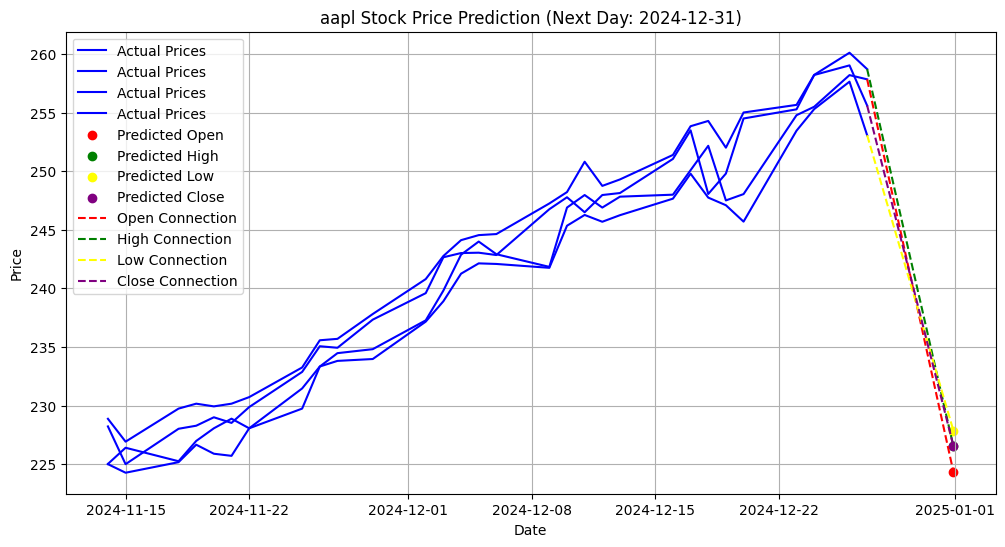

In [6]:
# Plot the actual prices
plt.figure(figsize=(12, 6))
plt.plot(data.index[-30:], data[['Open', 'High', 'Low', 'Close']].iloc[-30:], label='Actual Prices', color='blue')

# Plot the predicted prices
plt.scatter(predicted_date, predicted_next_day[0, 0], color='red', label='Predicted Open')
plt.scatter(predicted_date, predicted_next_day[0, 1], color='green', label='Predicted High')
plt.scatter(predicted_date, predicted_next_day[0, 2], color='yellow', label='Predicted Low')
plt.scatter(predicted_date, predicted_next_day[0, 3], color='purple', label='Predicted Close')

# Connect the last actual price to the predicted price
last_actual_point = data.iloc[-1][['Open', 'High', 'Low', 'Close']].values  # Last actual prices
plt.plot(
    [data.index[-1], predicted_date],
    [last_actual_point[0], predicted_next_day[0, 0]],
    color='red', linestyle='--', label='Open Connection'
)
plt.plot(
    [data.index[-1], predicted_date],
    [last_actual_point[1], predicted_next_day[0, 1]],
    color='green', linestyle='--', label='High Connection'
)
plt.plot(
    [data.index[-1], predicted_date],
    [last_actual_point[2], predicted_next_day[0, 2]],
    color='yellow', linestyle='--', label='Low Connection'
)
plt.plot(
    [data.index[-1], predicted_date],
    [last_actual_point[3], predicted_next_day[0, 3]],
    color='purple', linestyle='--', label='Close Connection'
)

# Add labels, legend, and title
plt.title(f'{stock_symbol} Stock Price Prediction (Next Day: {predicted_date_str})')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()
